In [48]:
from mido import MidiFile,tick2second, MidiTrack, Message
import time
import glob
from keras import utils, Sequential, layers
from keras.callbacks import ModelCheckpoint
import numpy as np


In [49]:
!echo $CUDA_VISIBLE_DEVICES 

4


## Preprocessing

In [61]:
def getNotes(timeMido, veloMido, notesMido):
    start= time.time()
    print("getting midi files")
    folders = ["2004"]#,  "2008"],  "2009",  "2011",  "2013",  "2014",  "2015",  "2017"]
    files = 0
    for folder in folders:
        #path = "/home/paul/Projects/maestro-v1.0.0/"+ folder +"/*.midi"
        path = "/data/s1453440/maestro-v1.0.0-midi/maestro-v1.0.0/"+ folder +"/*.midi"
        for file in glob.glob(path):
            files +=1
            
            if (time.time() - start) > MAX_TIME_ALLOWED:
                break
            midi = MidiFile(file)
            for track in midi.tracks:
                for msg in track:
                    if msg.type == 'set_tempo':
                        tempo = msg.tempo
                    if not msg.is_meta and msg.type == 'note_on':
                        notesMido.append(msg.note)
                        timeMido.append(msg.time)
                        #veloMido.append(msg.velocity)
        print(files)
        
    return notesMido, timeMido, veloMido


In [62]:
start = time.time()
timeMido = []
veloMido = []
notesMido = []
MAX_TIME_ALLOWED = 300
files = 0

notesMido,timeMido,veloMido = getNotes(timeMido, veloMido, notesMido)


getting midi files
132


In [63]:
len(notes)

500

In [64]:
# input for notes
inputLength = 80
# get all pitch names
notes = np.unique(notesMido)
# create a dictionary to map pitches to integers
normNotes = np.array(notesMido) - 21
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(normNotes) - inputLength):
    network_input.append(normNotes[i:i+inputLength])
    network_output.append(normNotes[i + inputLength])


n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns ,inputLength, 1))
# normalize input
network_input = network_input / float(len(notes))
network_output = utils.to_categorical(network_output)


## prepare for input/output for timing

In [65]:
#map timeinterval to int
times = np.unique(timeMido)
notes = np.unique(notesMido)

time_to_int = dict((time, integer) for integer, time in enumerate(times))
normNotesMido = np.array(notesMido)/float(len(notes))
normTimeMido = np.array(timeMido)/float(len(times))

In [66]:
# input for time
inputLength = 80

network_input = []
network_output = []


for i in range(0, len(timeMido) - inputLength):
    network_input.append( [normNotesMido[i + 1:i + inputLength + 1],normTimeMido[i:i+inputLength]])
    network_output.append(time_to_int[timeMido[i + inputLength]])

In [67]:
n_patterns = len(network_input)
network_input = np.array(network_input)
net_in = []
for i in range(0, n_patterns):
    net_in.append(network_input[i].transpose())
network_input = np.array(net_in)

In [69]:
network_output = utils.to_categorical(network_output)

In [81]:
int_to_time = {integer: time for time, integer in time_to_int.items()}

## Training

In [134]:
normNotesMido

array([[[7.61363636e-01, 4.02993667e-03],
        [7.38636364e-01, 6.73575130e-02],
        [7.38636364e-01, 1.19746690e-01],
        ...,
        [5.68181818e-01, 1.72711572e-03],
        [8.40909091e-01, 1.15141048e-03],
        [7.84090909e-01, 8.05987334e-03]],

       [[7.38636364e-01, 6.73575130e-02],
        [7.38636364e-01, 1.19746690e-01],
        [7.95454545e-01, 1.09383995e-02],
        ...,
        [8.40909091e-01, 1.15141048e-03],
        [7.84090909e-01, 8.05987334e-03],
        [6.81818182e-01, 1.26655153e-02]],

       [[7.38636364e-01, 1.19746690e-01],
        [7.95454545e-01, 1.09383995e-02],
        [7.95454545e-01, 5.75705239e-04],
        ...,
        [7.84090909e-01, 8.05987334e-03],
        [6.81818182e-01, 1.26655153e-02],
        [4.65909091e-01, 1.15141048e-03]],

       ...,

       [[7.72727273e-01, 6.21761658e-02],
        [6.81818182e-01, 3.90328152e-01],
        [5.00000000e-01, 2.18767991e-02],
        ...,
        [5.00000000e-01, 5.75705239e-04],
     

In [273]:
model = Sequential()
model.add(layers.LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(times)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [275]:
%%time
filepath = "weights-improvementTime-{epoch:02d}-{loss:.4f}-bigger.hdf5"    

checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

model.fit(network_input, network_output, epochs=20, batch_size=64, callbacks=callbacks_list)

Epoch 1/20
   7488/1629980 [..............................] - ETA: 6:25:12 - loss: 4.6144

KeyboardInterrupt: 

## Generating Music

In [53]:
from keras.models import load_model

In [22]:
model = Sequential()
model.add(layers.LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(times)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [51]:
# Load the weights to each node
#model.load_weights("/home/s1453440/Projects/neural-networks-2/weights-improved-Time-01-4.3212-bigger.hdf5")


In [54]:
model = load_model("/data/s1453440/myModel.h5")

In [92]:
start = np.random.randint(0, len(network_input)-1)
pattern = network_input[start]
prediction_output = []

inputs = []

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    #prediction_input = prediction_input / float(len(notes))
    prediction = model.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = index + 21
    prediction_output.append(result)
    pattern = np.append(pattern, index/float(len(notes)))
    pattern = pattern[1:len(pattern)]

In [84]:
output_notes = []
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track.append(Message('program_change', program=0, time=0))

for count,pnote in enumerate(prediction_output):
    rand = np.random.randint(0,8)
    interval = rand * 6
    track.append(Message('note_on', note=pnote, velocity=64, time=60 + interval))
    track.append(Message('note_off', note=pnote, velocity=127, time=60 + interval))
        # increase offset each iteration so that notes do not stack
mid.save('new_song.mid')

### Random notes

In [85]:
output_notes = []
randmid = MidiFile()
track = MidiTrack()
randmid.tracks.append(track)
track.append(Message('program_change', program=0, time=0))
for count in range(500):
    pnote = np.random.randint(0,127)
    rand = np.random.randint(0,8)
    interval = rand * 6
    track.append(Message('note_on', note=pnote, velocity=64, time=60 + interval))
    track.append(Message('note_off', note=pnote, velocity=127, time=60 + interval))
        # increase offset each iteration so that notes do not stack
randmid.save('rand_song.mid')

End

## Generating Rhythm:
    

In [141]:
midi = MidiFile("/home/s1453440/Projects/neural-networks-2/new_song.mid")
notesfromFile = []
for track in midi.tracks:
    for msg in track:
        if not msg.is_meta and msg.type == 'note_on':
            notesfromFile.append(msg.note)

In [142]:
len(notesfromFile)

500

In [155]:
start = np.random.randint(0, len(network_input)-1)
pattern = network_input[start]
prediction_output = []
inputs = []

for note_index in range(len(notesfromFile)):
    prediction_input = np.reshape(pattern, (1, len(pattern),2 ))
    #prediction_input = prediction_input / float(len(notes))
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_time[index]
    next_note = notes[note_index]/len(notes)
    if note_index > 10:
        if prediction_output[note_index -4] == prediction_output[note_index -3]: 
            if prediction_output[note_index - 3] == prediction_output[-2]:
                if prediction_output[note_index - 2] == prediction_output[note_index - 1]:
                    rand = np.random.randint(0,8)
                    result = rand * 6
    prediction_output.append(result)
    arr = np.array([next_note, time_to_int[result]/len(times)])
    pattern = np.vstack((pattern,arr))
    pattern = pattern[1:len(pattern)]

In [159]:
output_notes = []
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track.append(Message('program_change', program=0, time=0))

notesfromFile
for pnote,interval in zip(notesfromFile, prediction_output):
    rand = np.random.randint(0,4)
    if interval < 10:
        interval = rand * 3
    track.append(Message('note_on', note=pnote, velocity=64, time=100 + interval))
    track.append(Message('note_off', note=pnote, velocity=127, time=100 + interval))
        # increase offset each iteration so that notes do not stack
mid.save('song_ryhtm.mid')

In [163]:
import matplotlib.pyplot as plt

In [177]:
epoch = [1,2,3,4,5,6,7,8,9,10]
lossR = [3.34, 4.35, 4.36, 4.34, 4.40, 4.41, 4.38, 4.39, 4.41, 4.37]
lossN = [3.19, 3.18, 3.167, 3.165, 3.168, 3.18, 3.17, 3.17, 3.175, 3.18]

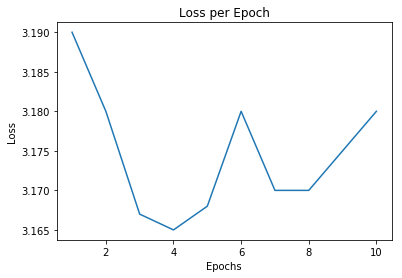

In [178]:
plt.plot(epoch, lossN)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.savefig("loss_epoch")